<a href="https://colab.research.google.com/github/viswapriyaG/Projectwork2/blob/main/Phishing_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyppeteer nest_asyncio scikit-learn imblearn opencv-python requests beautifulsoup4
!apt-get install xvfb -y
!apt-get install chromium-chromedriver


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.12).
0 upgraded, 0 newly installed, 0 to remove and 21 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
chromium-chromedriver is already the newest version (1:85.0.4183.83-0ubuntu2.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 21 not upgraded.


In [ ]:
import os
import pandas as pd
import requests
import socket
import cv2
import numpy as np
import joblib
import re
import asyncio
import nest_asyncio
from bs4 import BeautifulSoup
from urllib.parse import urlparse
from skimage.metrics import structural_similarity as ssim
from IPython.display import display
from PIL import Image
from pyppeteer import launch
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE

In [ ]:
nest_asyncio.apply()

In [ ]:
def extract_url_features(url):
    """Extract features from the given URL."""
    parsed_url = urlparse(url)
    domain = parsed_url.netloc.lower()

    url_length = len(url)
    has_https = 1 if parsed_url.scheme == "https" else 0
    num_hyphens = url.count('-')
    num_underscores = url.count('_')
    num_slashes = url.count('/')
    num_dots = url.count('.')
    num_digits = sum(c.isdigit() for c in url)
    has_at_symbol = 1 if "@" in url else 0
    has_ip_address = 1 if re.match(r'^\d{1,3}(\.\d{1,3}){3}', domain) else 0

    return [has_https, num_hyphens, num_underscores, num_slashes, num_dots, num_digits, has_at_symbol, has_ip_address]

In [ ]:
def extract_content_features(url):
    """Extracts HTML-based phishing indicators like form fields, JavaScript, and phishing keywords."""

    try:
        response = requests.get(url, timeout=5)
        soup = BeautifulSoup(response.text, 'html.parser')
    except:
        return [0, 0, 0, 0]  # Return default values if the page cannot be accessed

    # Count login forms
    login_forms = len(soup.find_all('form', {'action': re.compile(r'login|signin', re.IGNORECASE)}))

    # Count suspicious keywords in the content
    phishing_keywords = ['confirm', 'secure', 'verify', 'update', 'password', 'bank']
    keyword_count = sum(1 for keyword in phishing_keywords if keyword in soup.text.lower())

     # Count JavaScript elements (phishing sites often use obfuscation)
    js_scripts = len(soup.find_all('script'))

    # Count suspicious iframes (often used for phishing)
    iframe_count = len(soup.find_all('iframe'))

    return [login_forms, keyword_count, js_scripts, iframe_count]


In [ ]:
async def capture_screenshot(url):
    """Captures a screenshot using Pyppeteer (Works in Google Colab)."""
    try:
        # Create the screenshots folder if it doesn't exist
        screenshot_folder = "screenshots"
        os.makedirs(screenshot_folder, exist_ok=True)

        filename = urlparse(url).netloc + ".png"  # Extract domain name
        screenshot_path = f"{screenshot_folder}/{filename}"

        print(f" Capturing screenshot for: {url}...")

        # Launch headless browser
        browser = await launch(headless=True, args=['--no-sandbox', '--disable-setuid-sandbox'])
        page = await browser.newPage()
        await page.setViewport({"width": 1280, "height": 720})
        await page.goto(url, {"waitUntil": "load"})  # Ensure full page loads
        await page.screenshot({"path": screenshot_path})  # Save screenshot
        await browser.close()

        # Check if the screenshot was saved
        if os.path.exists(screenshot_path):
            print(f" Screenshot saved at: {screenshot_path}")
            return screenshot_path
        else:
            print(f" Screenshot NOT saved for {url}")
            return None

    except Exception as e:
        print(f" Error capturing screenshot for {url}: {str(e)}")
        return None

In [ ]:
file_path = "Website_Phishing.csv"
df = pd.read_csv(file_path)


In [ ]:
# Define Features
features = ['SFH', 'popUpWidnow', 'SSLfinal_State', 'Request_URL',
            'URL_of_Anchor', 'web_traffic', 'URL_Length',
            'age_of_domain', 'having_IP_Address']
target = 'Result'

df = df.dropna(subset=features + [target])

In [ ]:
X = df[features]
y = df[target].map({-1: 1, 0: 1, 1: 0})

In [ ]:
# Balance dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [ ]:
# Normalize Features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_resampled)


In [ ]:
# Train & Evaluate Multiple Models
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Logistic Regression": LogisticRegression(),
    "SVM": SVC(kernel='linear'),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42)
}

best_model = None
best_accuracy = 0

for model_name, model in models.items():
    print(f"\nTraining {model_name}...")
    model.fit(X_scaled, y_resampled)
    accuracy = accuracy_score(y_resampled, model.predict(X_scaled))
    print(f"{model_name} Accuracy: {accuracy:.4f}")

    if accuracy > best_accuracy:
        best_model = model
        best_accuracy = accuracy



Training Random Forest...
Random Forest Accuracy: 0.9683

Training Logistic Regression...
Logistic Regression Accuracy: 0.8689

Training SVM...
SVM Accuracy: 0.8733

Training Gradient Boosting...
Gradient Boosting Accuracy: 0.9354


In [ ]:
# Save the best model
joblib.dump(best_model, "best_phishing_model.pkl")
joblib.dump(scaler, "scaler.pkl")
print(f"\n Best Model Saved: {best_model}")


 Best Model Saved: RandomForestClassifier(random_state=42)


In [ ]:
def predict_website(url):
    """Predict whether a website is phishing or legitimate using URL & Content features."""

    # Extract Features
    url_features = extract_url_features(url)
    content_features = extract_content_features(url)

    # Debug Feature Counts
    print(f"URL Features ({len(url_features)}): {url_features}")
    print(f"Content Features ({len(content_features)}): {content_features}")

    # Ensure Correct Feature Count
    features = url_features + content_features
    if len(features) != 9:
        raise ValueError(f"Feature count mismatch! Expected 9, but got {len(features)}")

    # Convert to NumPy array & Reshape
    features_array = np.array(features).reshape(1, -1)

    # Load Model & Scaler
    model = joblib.load("best_phishing_model.pkl")
    scaler = joblib.load("scaler.pkl")

    # Normalize Features & Predict
    features_scaled = scaler.transform(features_array)
    prediction = model.predict(features_scaled)[0]

    return "Phishing" if prediction == 0 else "Legitimate"




In [ ]:
def extract_url_features(url):
    """Extract features related to URL structure."""
    features = []

    # Example URL-based features
    features.append(1 if "https" in url else 0)  # SSL usage
    features.append(len(url))  # URL length
    features.append(1 if "@" in url else 0)  # '@' symbol presence
    features.append(1 if url.count('.') > 2 else 0)  # Subdomain count
    features.append(1 if "-" in url else 0)  # Hyphen usage
    features.append(1 if "?" in url or "&" in url else 0)  # Query parameters presence

    print(f" URL Features Extracted ({len(features)}): {features}")
    return features

In [ ]:
def extract_content_features(url):
    """Extract content-based features by fetching webpage data."""
    features = []

    try:
        response = requests.get(url, timeout=5)
        soup = BeautifulSoup(response.text, "html.parser")

        # Example content-based features
        features.append(1 if soup.find("iframe") else 0)  # Iframe presence
        features.append(1 if soup.find("script") else 0)  # JavaScript presence
        features.append(1 if soup.find("form") else 0)  # Form presence

    except Exception as e:
        print(f" Error fetching {url}: {e}")
        features.extend([0, 0, 0])  # Default values if request fails

    print(f" Content Features Extracted ({len(features)}): {features}")
    return features

Testing https://www.google.com...
 URL Features Extracted (6): [1, 22, 0, 0, 0, 0]
 Content Features Extracted (3): [0, 1, 1]
URL Features (6): [1, 22, 0, 0, 0, 0]
Content Features (3): [0, 1, 1]
🎯 Prediction: Legitimate
 Capturing screenshot for: https://www.google.com...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


 Screenshot saved at: screenshots/www.google.com.png


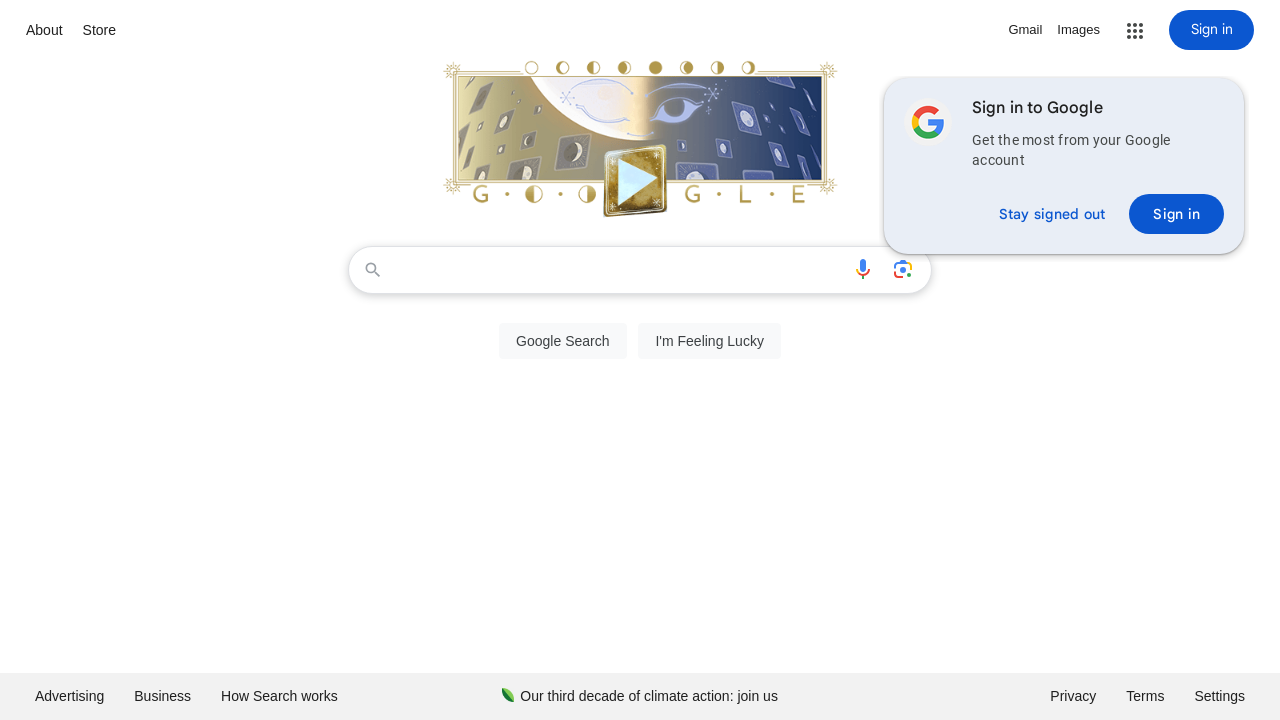

In [ ]:
test_urls = [
    "https://www.google.com"
]

for url in test_urls:
    print(f"Testing {url}...")
    result = predict_website(url)
    print(f"🎯 Prediction: {result}")
    loop = asyncio.get_event_loop()
    screenshot_path = loop.run_until_complete(capture_screenshot(url))

    if screenshot_path and os.path.exists(screenshot_path):
        img = Image.open(screenshot_path)
        display(img)
